*Random* forest classifier using scikit-learn


Import modules

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

Loading dataset


In [4]:
df = pd.read_json('dataset/complaints.json.zip', dtype=str)

In [5]:
df.head()

,date_received,product,sub_product,issue,sub_issue,complaint_what_happened,company_public_response,company,state,zip_code,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response,timely,consumer_disputed,complaint_id
0,2019-06-13,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,,,CAPITAL ONE FINANCIAL CORPORATION,PA,186XX,,Consent not provided,Web,2019-06-13,Closed with explanation,Yes,N/A,3274605
1,2019-11-01,Vehicle loan or lease,Loan,Struggling to pay your loan,Denied request to lower payments,I contacted Ally on Friday XX/XX/XXXX after fa...,Company has responded to the consumer and the ...,ALLY FINANCIAL INC.,NJ,088XX,,Consent provided,Web,2019-11-01,Closed with explanation,Yes,N/A,3425257
2,2019-04-01,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",PA,19067,,Consent not provided,Web,2019-04-01,Closed with explanation,Yes,N/A,3198225
3,2019-07-18,"Credit reporting, credit repair services, or o...",Credit repair services,Unexpected or other fees,,In XXXX I retained Freedom Debt Relief to help...,,FREEDOM FINANCIAL NETWORK,OH,440XX,,Consent provided,Web,2019-07-22,Closed with monetary relief,Yes,N/A,3310591
4,2019-08-08,Mortgage,Conventional home mortgage,Trouble during payment process,,,Company has responded to the consumer and the ...,"FLAGSTAR BANK, FSB",ID,83706,,N/A,Referral,2019-08-15,Closed with explanation,Yes,N/A,3342290


Select dataset columns

In [6]:
df['complaint_what_happened'].replace('', np.nan, inplace=True)
df.dropna(subset=['complaint_what_happened'], inplace=True)
# df = df.head(4096)

In [7]:
df.shape

(788820, 18)

In [8]:
df.isnull().sum()

date_received                0
product                      0
sub_product                  0
issue                        0
sub_issue                    0
complaint_what_happened      0
company_public_response      0
company                      0
state                        0
zip_code                     0
tags                         0
consumer_consent_provided    0
submitted_via                0
date_sent_to_company         0
company_response             0
timely                       0
consumer_disputed            0
complaint_id                 0
dtype: int64

In [9]:
df = df[['company_response', 'complaint_what_happened','company_public_response']]

In [10]:
df.isnull().sum()

company_response           0
complaint_what_happened    0
company_public_response    0
dtype: int64

In [11]:
df['company_response'].value_counts()

Closed with explanation            659938
Closed with non-monetary relief     83310
Closed with monetary relief         37504
Untimely response                    4215
Closed                               3741
In progress                           111
                                        1
Name: company_response, dtype: int64

In [12]:
df['company_public_response'].value_counts()

                                                                                                                           403597
Company has responded to the consumer and the CFPB and chooses not to provide a public response                            301038
Company believes it acted appropriately as authorized by contract or law                                                    45601
Company chooses not to provide a public response                                                                            19818
Company believes the complaint is the result of a misunderstanding                                                           4573
Company disputes the facts presented in the complaint                                                                        4210
Company believes complaint is the result of an isolated error                                                                2792
Company believes complaint caused principally by actions of third party outside the contro

In [13]:
actions={'Company has responded to the consumer and the CFPB and chooses not to provide a public response':'Dispute',
         'Company believes it acted appropriately as authorized by contract or law':'Dispute',
         'Company chooses not to provide a public response':'Dispute',
          'Company believes the complaint is the result of a misunderstanding':'Agrees',
         'Company disputes the facts presented in the complaint':'Dispute',
          'Company believes complaint is the result of an isolated error':'Agrees',
          'Company believes complaint caused principally by actions of third party outside the control or direction of the company':'Dispute',
          'Company believes complaint represents an opportunity for improvement to better serve consumers':'Agrees',
          "Company can't verify or dispute the facts in the complaint":'Less informative',
          "Company believes the complaint provided an opportunity to answer consumer's questions":'Agrees',
          'Company believes complaint relates to a discontinued policy or procedure':'Dispute',
         }

In [14]:
df['actions']=df['company_public_response'].map(actions)

In [15]:
df.head()

,company_response,complaint_what_happened,company_public_response,actions
1,Closed with explanation,I contacted Ally on Friday XX/XX/XXXX after fa...,Company has responded to the consumer and the ...,Dispute
3,Closed with monetary relief,In XXXX I retained Freedom Debt Relief to help...,,NaN
5,Closed with explanation,Hello This complaint is against the three cred...,Company has responded to the consumer and the ...,Dispute
6,Closed with explanation,I am a victim of Identity Theft & currently ha...,Company has responded to the consumer and the ...,Dispute
7,Closed with explanation,I have a active XXXX XXXX credit card in good ...,Company has responded to the consumer and the ...,Dispute


In [16]:
df.dropna(subset=['actions'], inplace=True)
df.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)

,company_response,complaint_what_happened,company_public_response,actions
1,Closed with explanation,I contacted Ally on Friday XX/XX/XXXX after fa...,Company has responded to the consumer and the ...,Dispute
5,Closed with explanation,Hello This complaint is against the three cred...,Company has responded to the consumer and the ...,Dispute
6,Closed with explanation,I am a victim of Identity Theft & currently ha...,Company has responded to the consumer and the ...,Dispute
7,Closed with explanation,I have a active XXXX XXXX credit card in good ...,Company has responded to the consumer and the ...,Dispute
9,Closed with non-monetary relief,Two accounts are still on my credit history af...,Company has responded to the consumer and the ...,Dispute
...,...,...,...,...
2275556,Closed with explanation,I have received calls and notices in regards t...,Company believes it acted appropriately as aut...,Dispute
2275560,Closed with non-monetary relief,Near the end of XXXX 2016 I opened a Citigold ...,Company has responded to the consumer and the ...,Dispute
2275568,Closed with explanation,On XX/XX/XXXX I purchased a XXXX XXXX XXXX XXX...,Company has responded to the consumer and the ...,Dispute
2275572,Closed with non-monetary relief,cfbp i would Like to file a complaint on Exper...,Company has responded to the consumer and the ...,Dispute


In [17]:
df.shape

(385223, 4)

In [18]:
df['company_public_response'].isnull().sum()

0

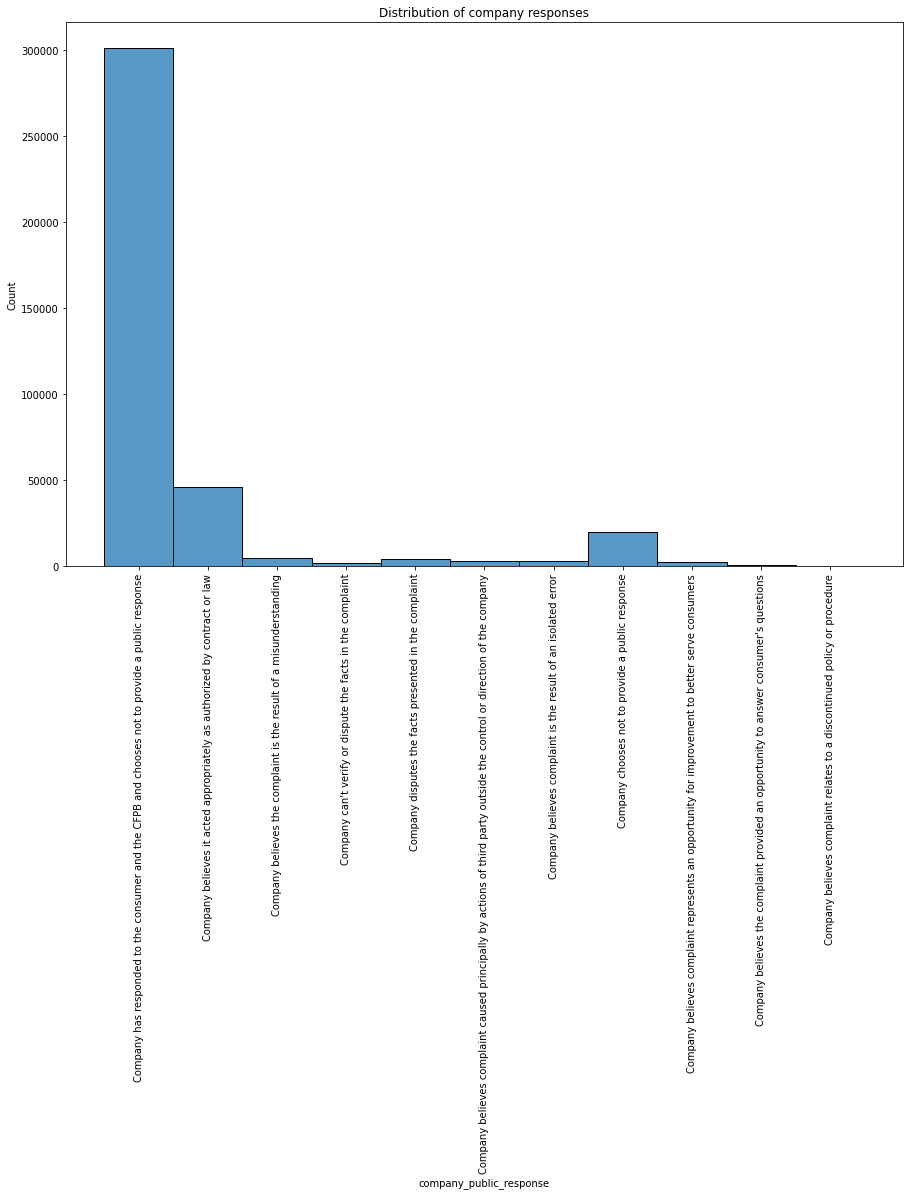

In [19]:
plt.figure(figsize=(15, 10))
sns.histplot(x='company_public_response', data=df)
plt.xticks(rotation=90)
plt.title('Distribution of company responses')
plt.show()

In [20]:
df.rename(columns={'complaint_what_happened':'complaint'}, inplace=True)
df.head()

,company_response,complaint,company_public_response,actions
1,Closed with explanation,I contacted Ally on Friday XX/XX/XXXX after fa...,Company has responded to the consumer and the ...,Dispute
5,Closed with explanation,Hello This complaint is against the three cred...,Company has responded to the consumer and the ...,Dispute
6,Closed with explanation,I am a victim of Identity Theft & currently ha...,Company has responded to the consumer and the ...,Dispute
7,Closed with explanation,I have a active XXXX XXXX credit card in good ...,Company has responded to the consumer and the ...,Dispute
9,Closed with non-monetary relief,Two accounts are still on my credit history af...,Company has responded to the consumer and the ...,Dispute


In [38]:
import nltk
import time
import sys

nltk.download('wordnet')

def cleanupText(row):
    import re
    import re
    #from wordcloud import WordCloud, STOPWORDS
    from nltk.tokenize import word_tokenize
    tweet = row
    #Lower case
    tweet.lower()
    #Removes unicode strings like "\u002c" and "x96"
    tweet = re.sub(r'(\\u[0-9A-Fa-f]+)',r"", tweet)
    tweet = re.sub(r'[^\x00-\x7f]',r"",tweet)
    #convert any url to URL
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)
    #Convert any @Username to "AT_USER"
    tweet = re.sub('@[^\s]+','AT_USER',tweet)
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    tweet = re.sub('[\n]+', ' ', tweet)
    #Remove not alphanumeric symbols white spaces
    tweet = re.sub(r'[^\w]', ' ', tweet)
    #Removes hastag in front of a word """
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #Remove :( or :)
    tweet = tweet.replace(':)',"")
    tweet = tweet.replace(':(',"")
    #remove numbers
    tweet = "".join([i for i in tweet if not i.isdigit()])
    #remove multiple exclamation
    tweet = re.sub(r"(\!)\1+", ' ', tweet)
    #remove multiple question marks
    tweet = re.sub(r"(\?)\1+", ' ', tweet)
    #remove multistop
    tweet = re.sub(r"(\.)\1+", ' ', tweet)
    #lemma
    from textblob import Word
    tweet =" ".join([Word(word).lemmatize() for word in tweet.split()])
    #stemmer
    #st = PorterStemmer()
    #tweet=" ".join([st.stem(word) for word in tweet.split()])
    #Removes emoticons from text
    tweet = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', "", tweet)
    #trim
    tweet = tweet.strip('\'"')
    row = tweet
    return row

start_time = time.time()
print('cleanup started', start_time, 's')
df['complaint'] = df['complaint'].apply(lambda x: cleanupText(x))
print('cleanup ended', time.time() - start_time, 's')


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nakshathru/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


cleanup started 1632833319.7521422 s
cleanup ended 2.7640798091888428 s


In [22]:
# X=enc.fit_transform(selected_df[['issue','sub_issue','consumer_disputed','complaint_what_happened','product']]).toarray()     
# y=enc.fit_transform(selected_df[['company_response']]).toarray()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test


X_train, X_test, y_train, y_test = train_test_split(df['complaint'], df['actions'],random_state=0,test_size=0.3)

In [23]:
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [24]:
tfidf = TfidfVectorizer()
tfidf.fit(df['complaint'])
X_train_t = tfidf.transform(X_train)
X_test_t = tfidf.transform(X_test)

In [25]:
y_train

array([1, 1, 1, ..., 1, 1, 1])

Creating classifier

In [26]:
clf = RandomForestClassifier(n_estimators = 100)  

training

In [27]:
clf.fit(X_train_t, y_train)

RandomForestClassifier()

predicting accuracy

In [28]:
y_pred = clf.predict(X_test_t)
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

ACCURACY OF THE MODEL:  0.9758064516129032


visualization

In [29]:
print(metrics.classification_report(y_test, clf.predict(X_test_t), target_names=df['actions'].unique()))

                  precision    recall  f1-score   support

         Dispute       0.00      0.00      0.00        13
          Agrees       0.98      1.00      0.99       605
Less informative       0.00      0.00      0.00         2

        accuracy                           0.98       620
       macro avg       0.33      0.33      0.33       620
    weighted avg       0.95      0.98      0.96       620



/Users/nakshathru/Documents/ML-Algos/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nakshathru/Documents/ML-Algos/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nakshathru/Documents/ML-Algos/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [30]:
matr = confusion_matrix(y_test, clf.predict(X_test_t))

In [31]:
# Predicitng in real time
sentence = ["This company refuses to provide me verification andvalidation of debt"+ "per my right under the FDCPA.I do not believe this debt is mine."]
feature_sent = tfidf.transform(sentence)
pred = clf.predict(feature_sent)
print(pred)

[1]


In [32]:
print(sentence)
print("This has been predicted as:",pred[0])

['This company refuses to provide me verification andvalidation of debtper my right under the FDCPA.I do not believe this debt is mine.']
This has been predicted as: 1
